<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/Generate_normal_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
data_dir = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal"
csv_list = glob.glob(f"{data_dir}/*")
print(csv_list)

results = pd.DataFrame(columns=['file', 'average_normal'])




['/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/150.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/150_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/300.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/300_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/600.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/600_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/1200.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/1200_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/2400.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/2400_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/4800.csv', '/content/driv

In [18]:
# Loop through all the files
for csv_path in csv_list:
    # Read the file
    df = pd.read_csv(csv_path, encoding="cp932")

    # Check if the '正常' column exists in the DataFrame
    if '正常' in df.columns:
        # Calculate the average of the '正常' column
        average_normal = df['正常'].mean()

        # Append the result to the results DataFrame
        results = results.append({'file': os.path.basename(csv_path), 'average_normal': average_normal}, ignore_index=True)

results.sort_values(by='average_normal', ascending=False)

<ipython-input-18-87ff8d27fcdc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'file': os.path.basename(csv_path), 'average_normal': average_normal}, ignore_index=True)
<ipython-input-18-87ff8d27fcdc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'file': os.path.basename(csv_path), 'average_normal': average_normal}, ignore_index=True)
<ipython-input-18-87ff8d27fcdc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'file': os.path.basename(csv_path), 'average_normal': average_normal}, ignore_index=True)
<ipython-input-18-87ff8d27fcdc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

,file,average_normal
11,4800_negative.csv,0.957138
7,1200_negative.csv,0.956312
9,2400_negative.csv,0.952455
8,2400.csv,0.928504
5,600_negative.csv,0.815466
6,1200.csv,0.786072
4,600.csv,0.736174
10,4800.csv,0.624270
2,300.csv,0.566400
3,300_negative.csv,0.485135


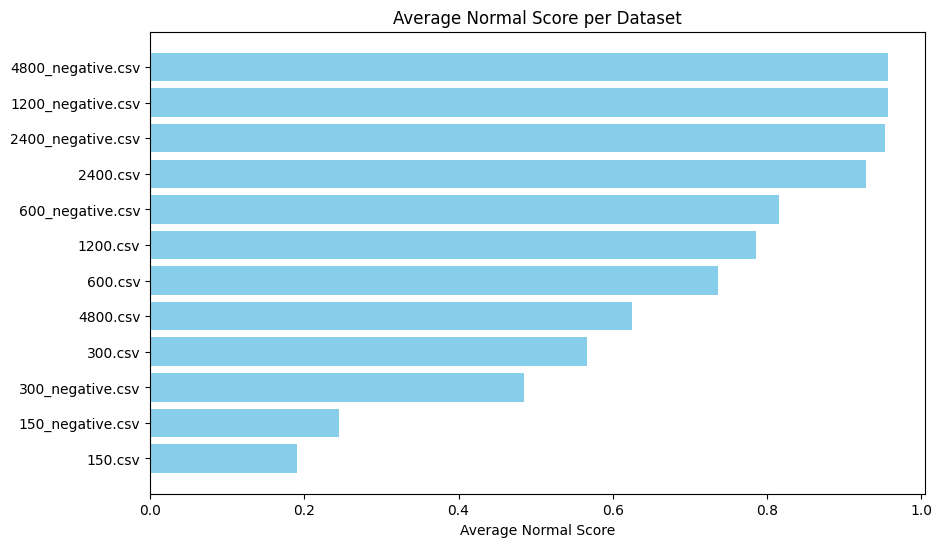

,file,average_normal
11,4800_negative.csv,0.957138
7,1200_negative.csv,0.956312
9,2400_negative.csv,0.952455
8,2400.csv,0.928504
5,600_negative.csv,0.815466
6,1200.csv,0.786072
4,600.csv,0.736174
10,4800.csv,0.624270
2,300.csv,0.566400
3,300_negative.csv,0.485135


In [20]:
# Sort results by average_normal
results_sorted = results.sort_values(by='average_normal', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(results_sorted['file'], results_sorted['average_normal'], color='skyblue')
plt.xlabel('Average Normal Score')
plt.title('Average Normal Score per Dataset')
plt.gca().invert_yaxis() # invert y-axis to display the highest score at the top
plt.show()

# Display the table
results_sorted.style.set_properties(**{'text-align': 'left'})

In [23]:
results_sorted

,file,average_normal,negative,step
11,4800_negative.csv,0.957138,True,4800
7,1200_negative.csv,0.956312,True,1200
9,2400_negative.csv,0.952455,True,2400
8,2400.csv,0.928504,False,2400
5,600_negative.csv,0.815466,True,600
6,1200.csv,0.786072,False,1200
4,600.csv,0.736174,False,600
10,4800.csv,0.624270,False,4800
2,300.csv,0.566400,False,300
3,300_negative.csv,0.485135,True,300


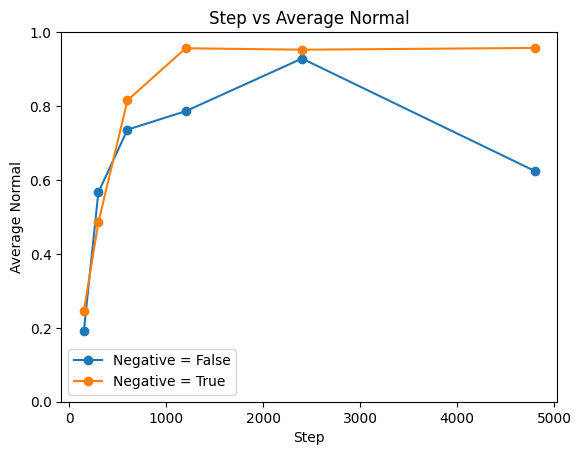

In [27]:
# 'negative'でグループ化し、'step'でソートします。
grouped = results_sorted.sort_values(by='step').groupby('negative')

# それぞれのグループに対して、折れ線グラフをプロットします。
for name, group in grouped:
    plt.plot(group['step'], group['average_normal'], marker='o', label=f"Negative = {name}")

plt.xlabel('Step')
plt.ylabel('Average Normal')
plt.title('Step vs Average Normal')
plt.ylim(0, 1.0)  # y軸の範囲を設定します。
plt.legend()
plt.show()